<a href="https://colab.research.google.com/github/romiaprilian7406/sp500-relative-valuation-estimation/blob/romiaprilian7406-patch-6/notebooks/sp500_relative_valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Global Configuration

In [2]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Data Loading

In [3]:
dataset_url = 'https://raw.githubusercontent.com/romiaprilian7406/sp500-relative-valuation-estimation/refs/heads/main/data/sp500_relative_valuation_dataset.csv'

try:
    df = pd.read_csv(dataset_url)
    print(f"Berhasil connect ke {dataset_url}")
    print(df.shape)
except Exception as e:
    print(f"Gagal connect: {e}")

Berhasil connect ke https://raw.githubusercontent.com/romiaprilian7406/sp500-relative-valuation-estimation/refs/heads/main/data/sp500_relative_valuation_dataset.csv
(377, 8)


# EDA

In [4]:
df_eda = df.copy()

## info

In [5]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          377 non-null    object 
 1   Sector          377 non-null    object 
 2   ROIC            373 non-null    float64
 3   Implied_Growth  362 non-null    float64
 4   TotalRevenue    377 non-null    float64
 5   ForwardPE       377 non-null    float64
 6   Beta            372 non-null    float64
 7   EV_EBITDA       377 non-null    float64
dtypes: float64(6), object(2)
memory usage: 23.7+ KB


In [6]:
target_col = 'EV_EBITDA'
num_cols = df.select_dtypes(include=[np.number]).columns.drop([target_col]).tolist()

## Statistics Descriptive

In [7]:
df_eda.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
ROIC,373.0,1.802867e-01,1.675718e-01,-1.384780e-01,7.312606e-02,1.366995e-01,2.359894e-01,1.094231e+00
Implied_Growth,362.0,6.481037e-01,1.439602e+00,-4.656460e-01,1.250734e-01,2.863512e-01,7.014319e-01,1.785808e+01
TotalRevenue,377.0,3.667632e+10,7.504812e+10,7.058230e+08,7.082300e+09,1.456612e+10,3.012700e+10,6.809850e+11
ForwardPE,377.0,2.047384e+01,1.930484e+01,-1.301315e+02,1.389002e+01,1.850236e+01,2.389621e+01,2.150175e+02
Beta,372.0,9.709059e-01,4.312591e-01,-7.600000e-02,6.365000e-01,9.935000e-01,1.253000e+00,2.536000e+00
EV_EBITDA,377.0,2.513014e+01,7.002047e+01,1.992344e+00,1.145528e+01,1.546397e+01,2.154022e+01,1.276282e+03


## Missing Values

In [8]:
missing = df_eda[num_cols].isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    missing_pct = (missing / len(df_eda)) * 100
    missing_df = pd.DataFrame({'Jumlah Hilang': missing, 'Persentase (%)': missing_pct})
    display(missing_df.style.background_gradient(cmap='Reds', subset=['Persentase (%)']).format("{:.2f}"))
else:
    print("Tidak ditemukan missing values")

,Jumlah Hilang,Persentase (%)
Implied_Growth,15.00,3.98
Beta,5.00,1.33
ROIC,4.00,1.06


## Target Distribution

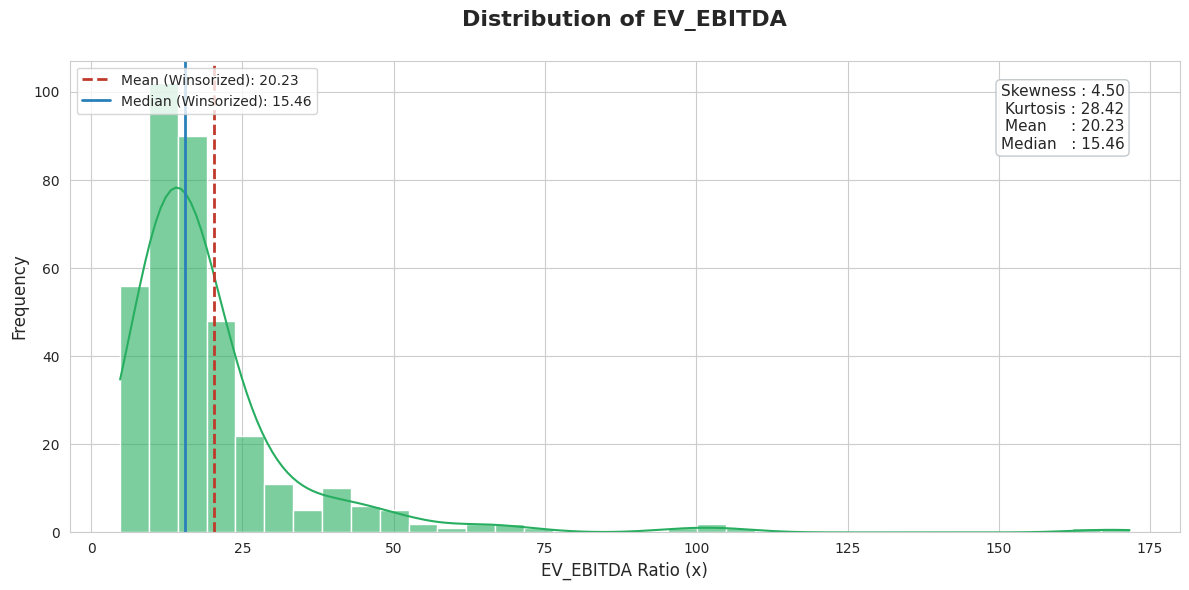

In [9]:
data_raw = df_eda[target_col].dropna()

# WINSORIZING (1% - 99%)
# Teknik ini "memangkas" 1% ekor kiri dan kanan HANYA untuk keperluan visualisasi
q_low = data_raw.quantile(0.01)
q_high = data_raw.quantile(0.99)
data_viz = data_raw[(data_raw >= q_low) & (data_raw <= q_high)]

# Statistik
mean_val = data_viz.mean()
median_val = data_viz.median()
skew_val = data_viz.skew()
kurt_val = data_viz.kurt()

# Visualisasi
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Histogram
sns.histplot(data_viz, kde=True, color='#27ae60', alpha=0.6, edgecolor='white', bins=35)

# Garis Referensi
plt.axvline(mean_val, color='#c0392b', linestyle='--', linewidth=2, label=f'Mean (Winsorized): {mean_val:.2f}')
plt.axvline(median_val, color='#2980b9', linestyle='-', linewidth=2, label=f'Median (Winsorized): {median_val:.2f}')

plt.title(f'Distribution of {target_col}', fontsize=16, fontweight='bold', pad=25)
plt.xlabel(f'{target_col} Ratio (x)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Statistik
stats_text = (f'Skewness : {skew_val:.2f}\n'
              f'Kurtosis : {kurt_val:.2f}\n'
              f'Mean     : {mean_val:.2f}\n'
              f'Median   : {median_val:.2f}')

props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#bdc3c7')
plt.gca().text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=11,
               verticalalignment='top', horizontalalignment='right', bbox=props)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Features Distribution

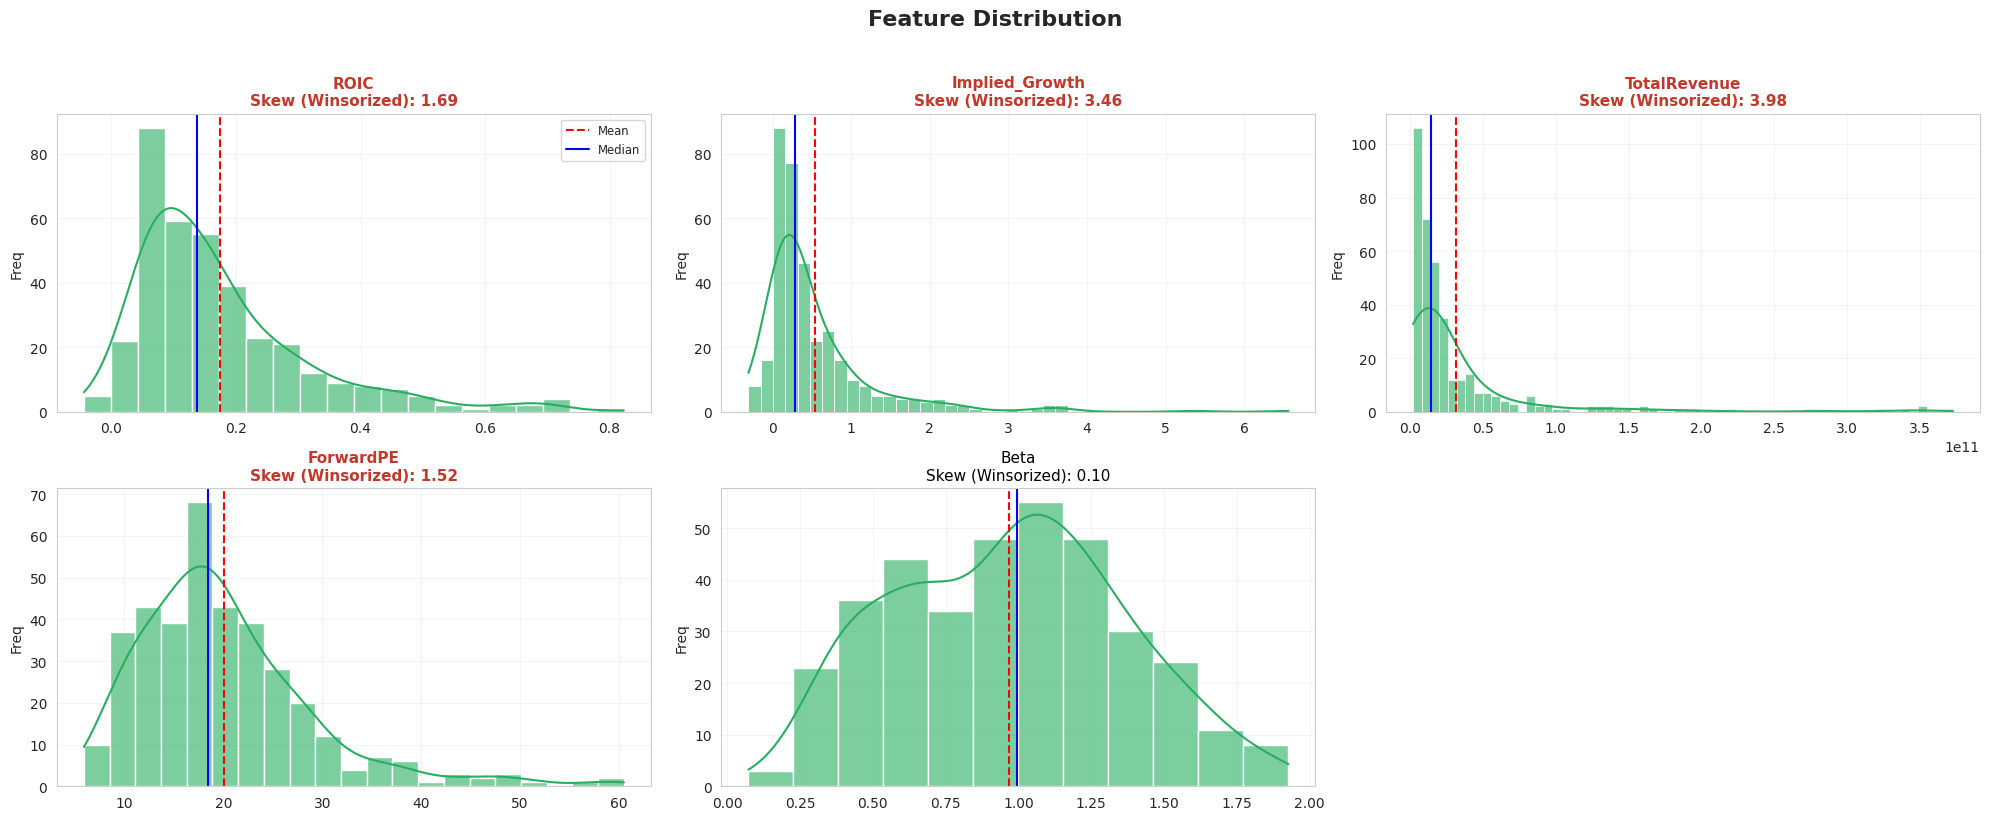

In [10]:
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(num_cols):

    # Data Prep (Winsorize 1-99% Visual Only)
    data_raw = df_eda[col].dropna()

    # Hitung batas quantile
    q_low = data_raw.quantile(0.01)
    q_high = data_raw.quantile(0.99)

    # Filter data untuk visualisasi
    data_viz = data_raw[(data_raw >= q_low) & (data_raw <= q_high)]

    # Plot Histogram (Hijau Standar)
    sns.histplot(data_viz, kde=True, ax=axs[i], color='#27ae60', alpha=0.6, edgecolor='white')

    # Hitung Statistik
    skew_val = data_viz.skew()
    mean_val = data_viz.mean()
    median_val = data_viz.median()

    # Tambahkan Garis Referensi (Mean & Median)
    # Ini membantu melihat apakah Mean tertarik ke kanan/kiri oleh outlier sisa
    axs[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label='Mean')
    axs[i].axvline(median_val, color='blue', linestyle='-', linewidth=1.5, label='Median')

    # Merah jika Skewness > 0.5 (Moderately Skewed) atau > 1 (Highly Skewed)
    is_skewed = abs(skew_val) > 0.5
    title_color = '#c0392b' if is_skewed else 'black'
    font_weight = 'bold' if is_skewed else 'normal'

    axs[i].set_title(f'{col}\nSkew (Winsorized): {skew_val:.2f}',
                     fontsize=11, fontweight=font_weight, color=title_color)

    # Kosmetik
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Freq')
    axs[i].grid(True, alpha=0.2)

    # Tampilkan legend hanya di plot pertama
    if i == 0:
        axs[i].legend(loc='upper right', fontsize='small')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Feature Distribution", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Ouliers

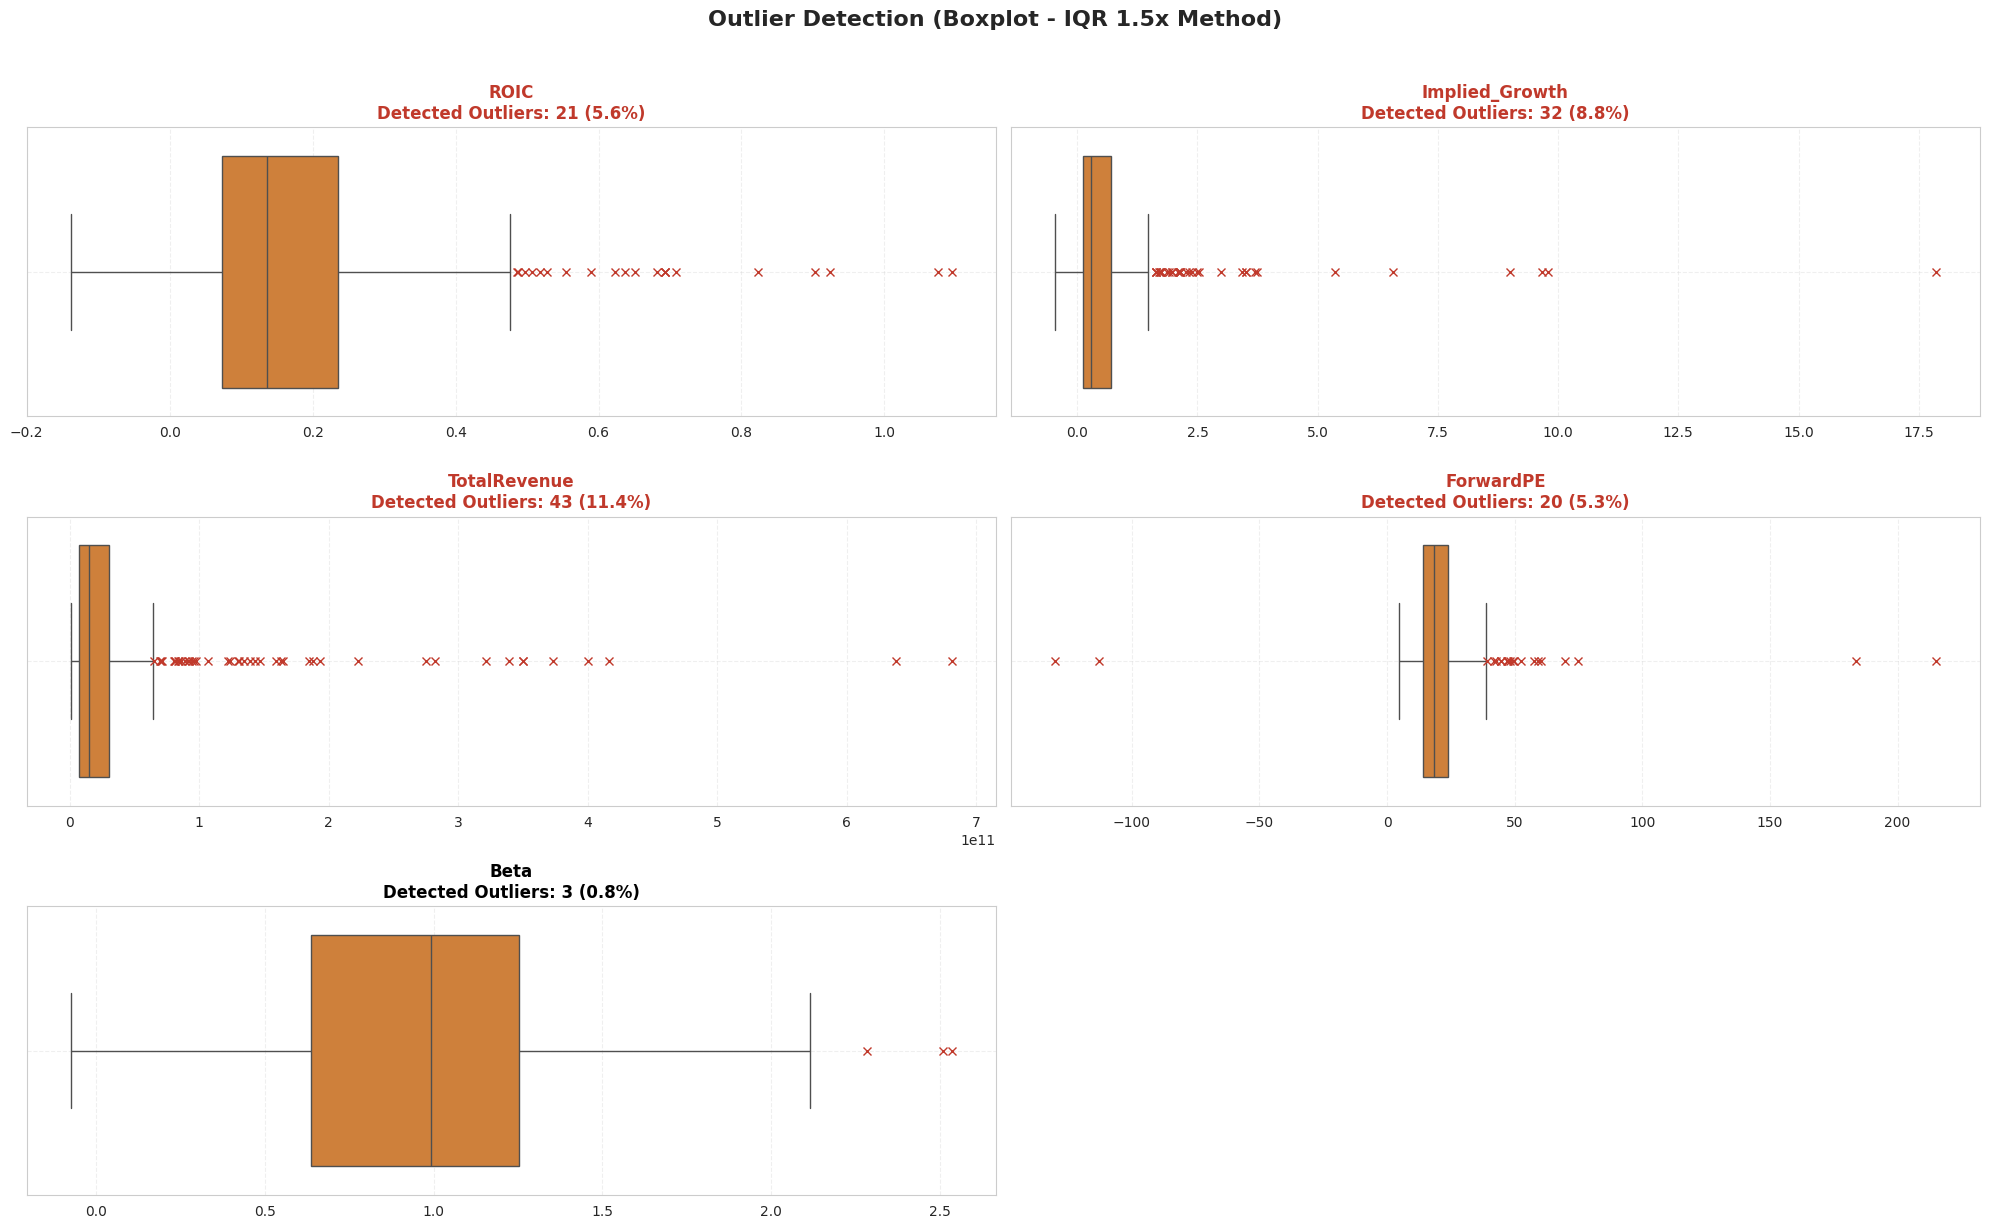

In [11]:
n_cols = 2
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(num_cols):

    # Ambil data bersih untuk perhitungan statistik
    data_clean = df_eda[col].dropna()

    # Hitung Statistik IQR Manual
    Q1 = data_clean.quantile(0.25)
    Q3 = data_clean.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hitung Jumlah & Persentase Outlier
    n_outliers = ((data_clean < lower_bound) | (data_clean > upper_bound)).sum()
    pct_outliers = (n_outliers / len(data_clean)) * 100

    # Visualisasi Boxplot
    # flierprops = properti untuk titik-titik outlier (kita buat silang merah biar jelas)
    sns.boxplot(x=df_eda[col], ax=axs[i], color='#e67e22',
                flierprops={"marker": "x", "markeredgecolor": "#c0392b", "markersize": 6})

    # Jika outlier > 5%, beri warna merah pada judul sebagai "Warning"
    title_color = '#c0392b' if pct_outliers > 5 else 'black'

    axs[i].set_title(f'{col}\nDetected Outliers: {n_outliers} ({pct_outliers:.1f}%)',
                     fontsize=12, fontweight='bold', color=title_color)

    axs[i].set_xlabel('')
    axs[i].grid(True, linestyle='--', alpha=0.3)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Outlier Detection (Boxplot - IQR 1.5x Method)", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Correlation Heatmap

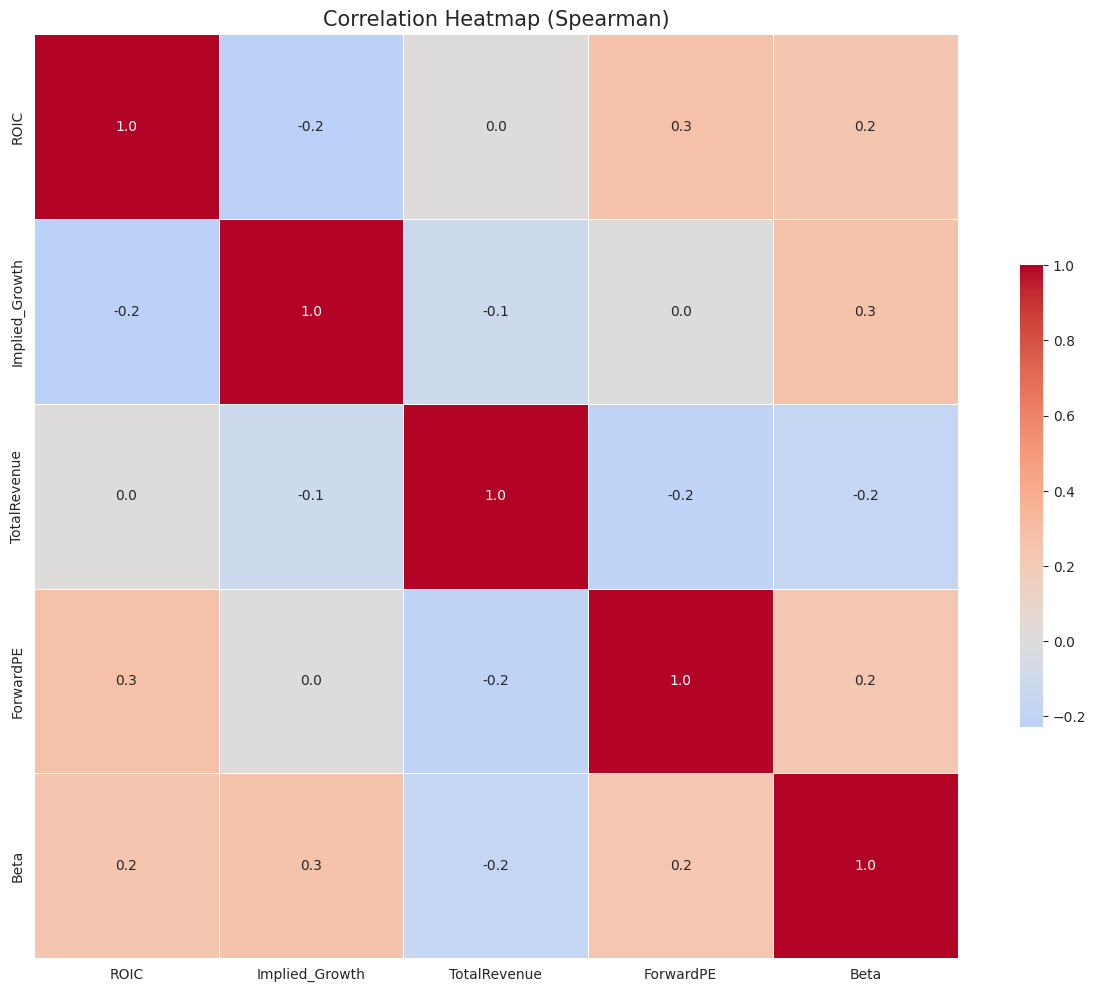

In [12]:
plt.figure(figsize=(16, 12))
corr = df_eda[num_cols].corr(method='spearman')

sns.heatmap(
    corr,
    annot=True,
    fmt=".1f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Correlation Heatmap (Spearman)', fontsize=15)
plt.show()

# Filtering Business Logic

In [13]:
print(f"Original Shape: {df.shape}")

# A. Scope Filtering (Business Logic for Fundamental Investing)
# Hapus baris dengan Target (EV_EBITDA) yang kosong
df = df.dropna(subset=['EV_EBITDA'])

# Fair Value (Hapus outlier ekstrem 1200x)
df = df[(df['EV_EBITDA'] > 4) & (df['EV_EBITDA'] < 40)]

# Profitable Companies Only
# Alasan: Relative valuation sulit bekerja pada perusahaan rugi (PE Negatif)
df = df[df['ForwardPE'] > 0]

# Revenue > 0 (Untuk menghindari error log)
df = df[df['TotalRevenue'] > 0]

# Log Transform untuk Revenue (Mengatasi skewness size perusahaan)
df['Log_Revenue'] = np.log1p(df['TotalRevenue'])

# Clipping Manual (Hard Limit) sebelum masuk Pipeline
# Tujuannya agar data training tidak memiliki nilai ekstrem yang membingungkan model
df['ROIC'] = df['ROIC'].clip(-0.5, 1.0)                      # Cap ROIC di -50% s/d 100%
df['Implied_Growth'] = df['Implied_Growth'].clip(-0.5, 1.0)  # Cap Growth
df['Beta'] = df['Beta'].fillna(1.0).clip(0.0, 3.0)           # Cap Risk (Beta)

print(f"Shape after filtering: {df.shape}")

Original Shape: (377, 8)
Shape after filtering: (337, 9)


# Data Splitting

In [14]:
features = ['Sector', 'ROIC', 'Implied_Growth', 'Log_Revenue', 'ForwardPE', 'Beta']

X = df[features]
y = df[target_col]

# Split 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical: Impute median
        ('num', SimpleImputer(strategy='median'),
         ['ROIC', 'Implied_Growth', 'Log_Revenue', 'ForwardPE', 'Beta']),

        # Categorical: OneHot (Sector)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         ['Sector'])
    ])

# Modeling

In [16]:
# Model: Gradient Boosting Regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=150,
                                            learning_rate=0.05,
                                            max_depth=2,
                                            subsample=0.7,
                                            random_state=42,
                                            loss='absolute_error'))
])

# Training
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['ROIC', 'Implied_Growth',
                                                   'Log_Revenue', 'ForwardPE',
                                                   'Beta']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sector'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.05,
                                           loss='absolute_error', max_depth=2,
                                           n_estimators=150, random_state=42,
                                           subsample=0.7))])

# Evaluation

In [17]:
# Ambil prediksi
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Ambil nilai asli
y_train_true = y_train.values if hasattr(y_train, 'values') else y_train
y_test_true = y_test.values if hasattr(y_test, 'values') else y_test

def get_metrics(y_true, y_pred):
    # R2 sebaiknya dilihat dari Log Scale untuk valuasi (relatif error), tapi inputnya tetap data real
    r2_log = r2_score(np.log1p(y_true), np.log1p(y_pred))

    mape = mean_absolute_percentage_error(y_true, y_pred)

    ape = np.abs((y_true - y_pred) / y_true)
    mdape = np.median(ape)

    return [r2_log, mape * 100, mdape * 100]

metrics_df = pd.DataFrame([get_metrics(y_train_true, y_train_pred),
                           get_metrics(y_test_true, y_test_pred)],
                          columns=['R² (Log Scale)', 'MAPE (%)', 'MdAPE (%)'],
                          index=['Training Set', 'Test Set'])

print("Evaluation Report")
display(metrics_df.round(3))

Evaluation Report


,R² (Log Scale),MAPE (%),MdAPE (%)
Training Set,0.665,17.247,8.952
Test Set,0.660,17.342,9.801


# Visualization

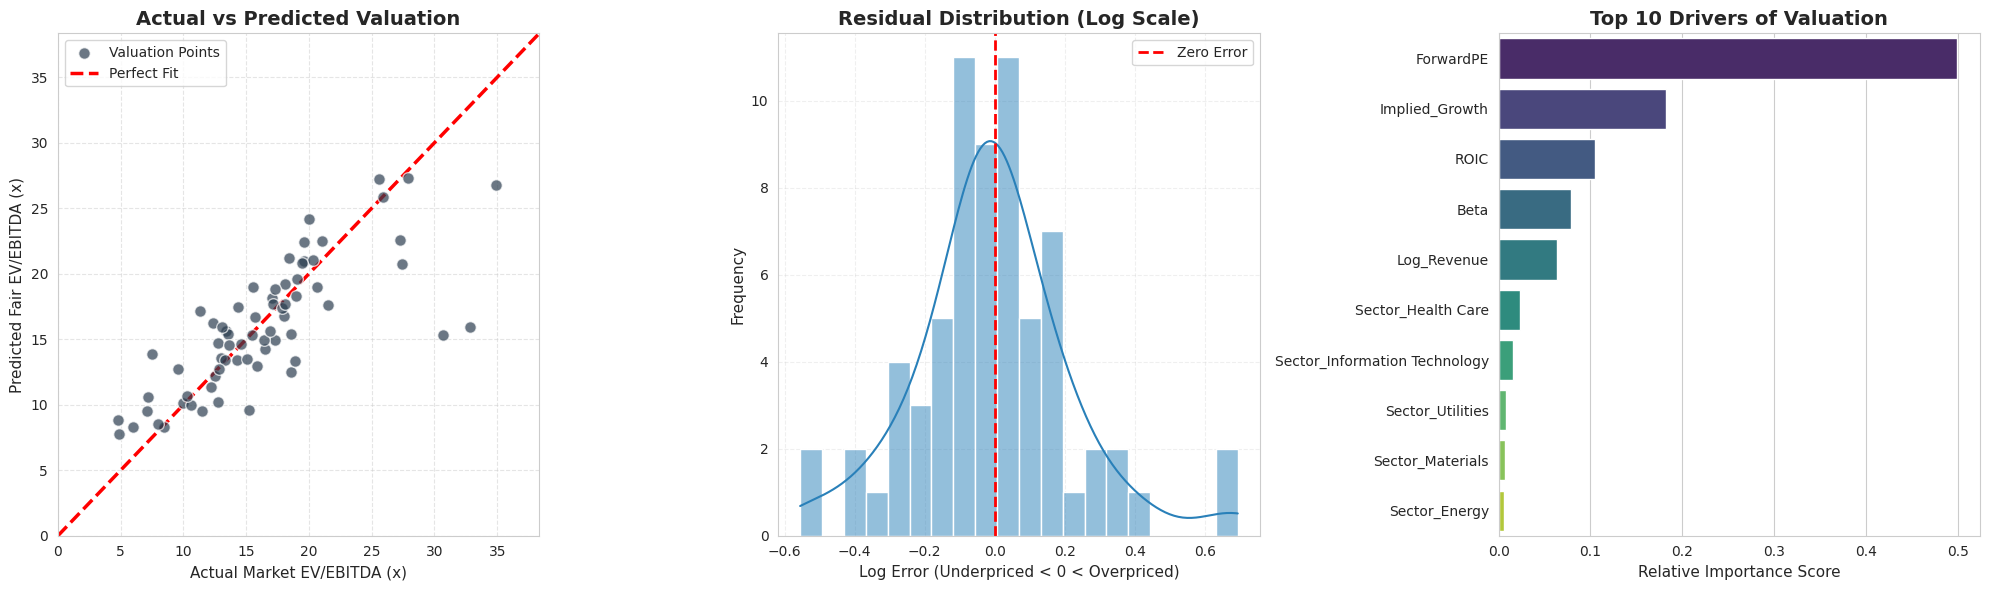

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# PLOT 1: ACTUAL VS PREDICTED
ax1 = axes[0]

# Tentukan batas axis (Max Value dari data asli)
# Misal max valuasi 40x, set limit sedikit di atasnya
limit_val = max(y_test_true.max(), y_test_pred.max()) * 1.1

# Scatter Plot (Titik Data)
ax1.scatter(y_test_true, y_test_pred,
            alpha=0.7, color='#2c3e50', edgecolor='white', s=70,
            label='Valuation Points', zorder=3)

# Garis Diagonal (Perfect Fit)
ax1.plot([0, limit_val], [0, limit_val], 'r--', lw=2.5, label='Perfect Fit')

# Kosmetik Plot
ax1.set_title("Actual vs Predicted Valuation", fontsize=14, fontweight='bold')
ax1.set_xlabel("Actual Market EV/EBITDA (x)", fontsize=11)
ax1.set_ylabel("Predicted Fair EV/EBITDA (x)", fontsize=11)
ax1.set_xlim(0, limit_val)
ax1.set_ylim(0, limit_val)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.5)


# PLOT 2: RESIDUAL DISTRIBUTION
ax2 = axes[1]
# Log Residuals (Agar berdistribusi normal)
residuals = np.log1p(y_test_true) - np.log1p(y_test_pred)

sns.histplot(residuals, kde=True, color='#2980b9', bins=20, edgecolor='white', ax=ax2)
ax2.axvline(0, color='r', linestyle='--', lw=2, label='Zero Error')
ax2.set_title("Residual Distribution (Log Scale)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Log Error (Underpriced < 0 < Overpriced)", fontsize=11)
ax2.set_ylabel("Frequency", fontsize=11)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.3)


# PLOT 3: FEATURE IMPORTANCE
ax3 = axes[2]
regressor = model.named_steps['regressor']
# Pastikan nama fitur sesuai urutan pipeline
num_features = ['ROIC', 'Implied_Growth', 'Log_Revenue', 'ForwardPE', 'Beta']
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
try:
    cat_features = list(ohe.get_feature_names_out())
except:
    cat_features = []

feature_names = num_features + cat_features

# Buat Series
if len(regressor.feature_importances_) == len(feature_names):
    feat_imp = pd.Series(regressor.feature_importances_, index=feature_names).sort_values(ascending=False).head(10)
    sns.barplot(x=feat_imp.values, y=feat_imp.index, hue=feat_imp.index, palette='viridis', legend=False, ax=ax3)
    ax3.set_title("Top 10 Drivers of Valuation", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Relative Importance Score", fontsize=11)
    ax3.set_ylabel("")
else:
    ax3.text(0.5, 0.5, "Feature Name Mismatch\nCheck Pipeline Order", ha='center')

plt.tight_layout()
plt.show()

# Export Model

In [19]:
model_filename = "sp500_valuation_model.joblib"
joblib.dump(model, model_filename)

print(f"Model disimpan ke: {model_filename}")

Model disimpan ke: sp500_valuation_model.joblib
